# GARCH(1,1) Application via Sequential Monte Carlo in Pymc3

* Questions, thoughts and possible further works are at the end of this notebook.

In [572]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
import seaborn as sns

import pymc3 as pm
from pymc3.distributions.timeseries import GARCH11
from pymc3 import smc, find_MAP, traceplot, plots
from scipy import optimize
import arviz as az
from scipy.optimize import minimize
from collections import deque

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn import gaussian_process
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, \
                                                    ExpSineSquared, RationalQuadratic, DotProduct

/Users/jinxiwen/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Function definitions

In [2]:
def normalize(data):
    ''' 
    normalize the input argument 'data',  
    so that input with different metric are able to compare
    '''
    mini = min(data)
    maxi = max(data)
    res = pd.Series(list(map(lambda x: (x-mini)/(maxi-mini), data)), index = data.index)
    return res


def update_vol(a0, a1, b1, vol, ret):
    '''calculate volatility'''
    return a0 + a1*(ret**2) + b1*vol


def vol_process(init, obs, a0, a1, b1):
    '''calculate volatilities and store them'''
    vol = [init]
    for y in obs:
        vol.append(a0 + a1*(y**2) + b1*vol[-1])
    return vol[1:]


def signals_3(lower, upper, vol_predavg, stoploss=0.05):
    '''
    trading signals generated by volatility predictions
    lower: lower level on each out of sample date
    upper: upper level on each out of sample date
    vol_predavg: time series of volatility prediction
    stoploss: max pct loss we want to tolerate, can be both pos or neg number as input
    '''
    long, short, close = [], [], []
    i, p = 0, 0
    while lower[i] <= vol_predavg[i] <= upper[i]:
        i += 1
        if i==len(vol_predavg): 
            i = len(vol_predavg)-1
            break

    if vol_predavg[i] < lower[i]: 
        p = 1
        long.append(vol_predavg.index[i])
    else:
        p = -1
        short.append(vol_predavg.index[i])
    
    cost = 0.
    for j in range(max(i,1), len(vol_predavg)):
        # stoploss control
        if (vol_predavg[j]-cost)/vol_predavg[j] < -np.abs(stoploss):
            close.append(vol_predavg.index[j])
            cost = 0.
        
        # short if volatility goes blow upper level
        if p==1 and vol_predavg[j-1]>upper[j-1] and vol_predavg[j]<upper[j]: 
            short.append(vol_predavg.index[j-1])
            cost = vol_predavg[j]
            p = -1
        
        # long if volatility goes above lower level
        if p==-1 and vol_predavg[j-1]<lower[j-1] and vol_predavg[j]>lower[j]:
            long.append(vol_predavg.index[j-1])
            cost = vol_predavg[j]
            p = 1
            
    return long, short, close





# Data preperation

SP500 and VIX index data are from Yahoo finance, it ranges from 2004-01-01 to 2019-5-17

VIX futures data are from Quandl, it ranges from 2005-6-20 to 2011-11-19, it's continuous contract Non-adjusted price based on spot-month continuous contract calculations.

Basically vix index & vix futrues price are highly correlated.

In [3]:
SP500 = pd.read_csv('SP500.csv')
SP500['Daily_Return'] = np.log(SP500.Close/SP500.Open)
SP500.Date = pd.to_datetime(SP500.Date)
SP500 = SP500.set_index('Date')

VIX = pd.read_csv('vix.csv')
VIX.Date = pd.to_datetime(VIX.Date)
VIX = VIX.set_index('Date')

VIX_F = pd.read_csv('VIX_F.csv')
VIX_F.Trade_Date = pd.to_datetime(VIX_F.Trade_Date)
VIX_F = VIX_F.set_index('Trade_Date')
VIX_F.Close[VIX_F.Close==0] = VIX_F.Settle[VIX_F.Close==0].to_list()

/Users/jinxiwen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


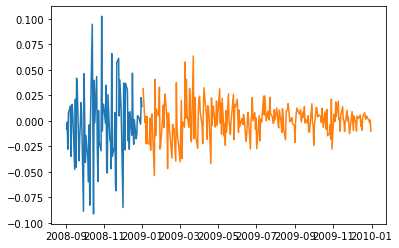

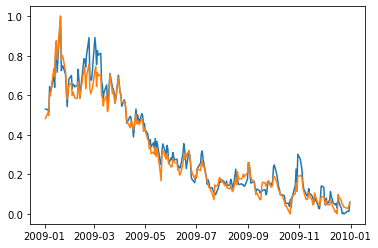

In [5]:
start = '2008-09-01'  # the start date for in-sample data
cut = '2008-12-31'    # the end date for in-sample data, the next available date of it is the start of hold-out data
end = '2009-12-31'     # the end date for out of sample data
next_start = dt.datetime.strptime(cut, '%Y-%m-%d') + dt.timedelta(days=1)  
next_start = dt.datetime.strftime(next_start, '%Y-%m-%d')

obs = SP500.Daily_Return[start:cut]
holdout_obs = SP500.Daily_Return[next_start:end]

vix = VIX[start:cut].Close
holdout_vix = VIX[next_start:end].Close
vix_f = VIX_F[start:cut].Close
holdout_vix_f = VIX_F[next_start:end].Close

# visualization of in & out of sample data
plt.plot(obs.index, obs)
plt.plot(holdout_obs.index, holdout_obs)
plt.show()

# plot vix index & vix futures trend
plt.plot(holdout_vix.index, normalize(holdout_vix))
plt.plot(holdout_vix_f.index, normalize(holdout_vix_f))
plt.show()

# Bayesian inference by pymc3

In [6]:
init = np.random.uniform(0., 0.0001) 
print(init)

with pm.Model() as GARCH:
    a0 = pm.Uniform('a0', 1e-5, 1., dtype='float64')
    a1 = pm.Uniform('a1', 1e-5, 1., dtype='float64')
    b1 = pm.Uniform('b1', 1e-5, 1-a1, dtype='float64')

    ret = GARCH11('ret', a0, a1, b1, initial_vol= init**2, shape = len(obs), observed = obs.values.flatten())
    trace = pm.sample(draws=1000, step=pm.SMC(), tune=500, progressbar=True)
    
post = pm.trace_to_dataframe(trace)

3.656167052972099e-05


Sample initial stage: ...
Stage: 0 Beta: 0.000 Steps: 25
Stage: 1 Beta: 0.013 Steps: 8
Stage: 2 Beta: 0.024 Steps: 3
Stage: 3 Beta: 0.042 Steps: 7
Stage: 4 Beta: 0.105 Steps: 4
Stage: 5 Beta: 0.295 Steps: 6
Stage: 6 Beta: 0.688 Steps: 5
Stage: 7 Beta: 1.000 Steps: 7


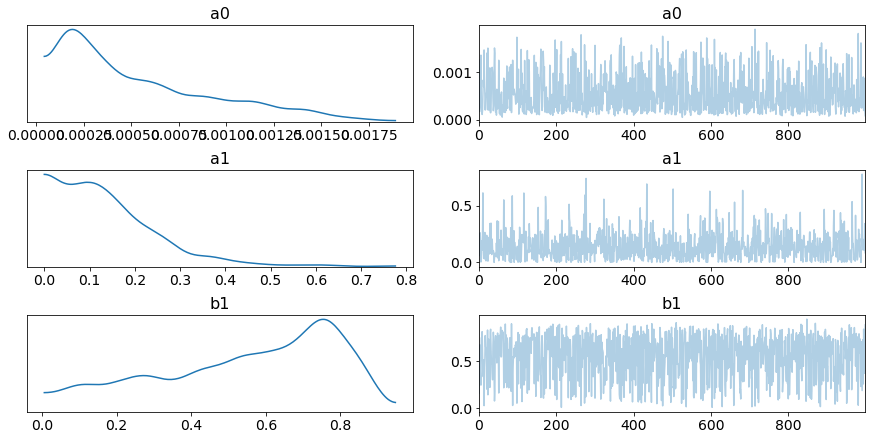

In [7]:
# plot posterior dist. for each parameters in GARCH
pm.traceplot(trace)
plt.show()

100%|██████████| 100/100 [00:01<00:00, 53.85it/s]


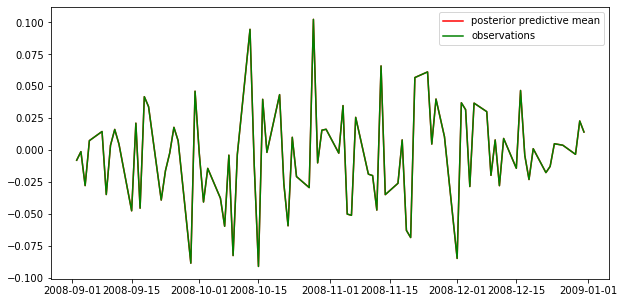

In [8]:
# sample from posterior distribution,
# to verify our model is defined correctly as GARCH(1,1)

with GARCH:
    ppc = pm.sample_posterior_predictive(trace, samples=100, progressbar=True)
    
plt.figure(figsize=(10, 5))
plt.plot(obs.index, np.mean(ppc['ret'], axis=0), label='posterior predictive mean', color='red')
plt.plot(obs.index, obs, color='green', label='observations')
plt.legend(loc='best')
plt.show()

# Calculate volatilities for in-sample time steps

In [9]:
vol = pd.DataFrame(index=obs.index)

for i in range(len(post)):
    vol[str(i)] = vol_process(init, obs, post.a0[i], post.a1[i], post.b1[i]) #, post.r_mu[i])
    
down = vol.quantile(0.005, axis=1) # lower quantile of volatility for each time step
up = vol.quantile(0.995, axis=1)   # upper quantile of volatility for each time step
vol_avg = vol.mean(axis=1)         # mean of volatility predictive distribution of each time step

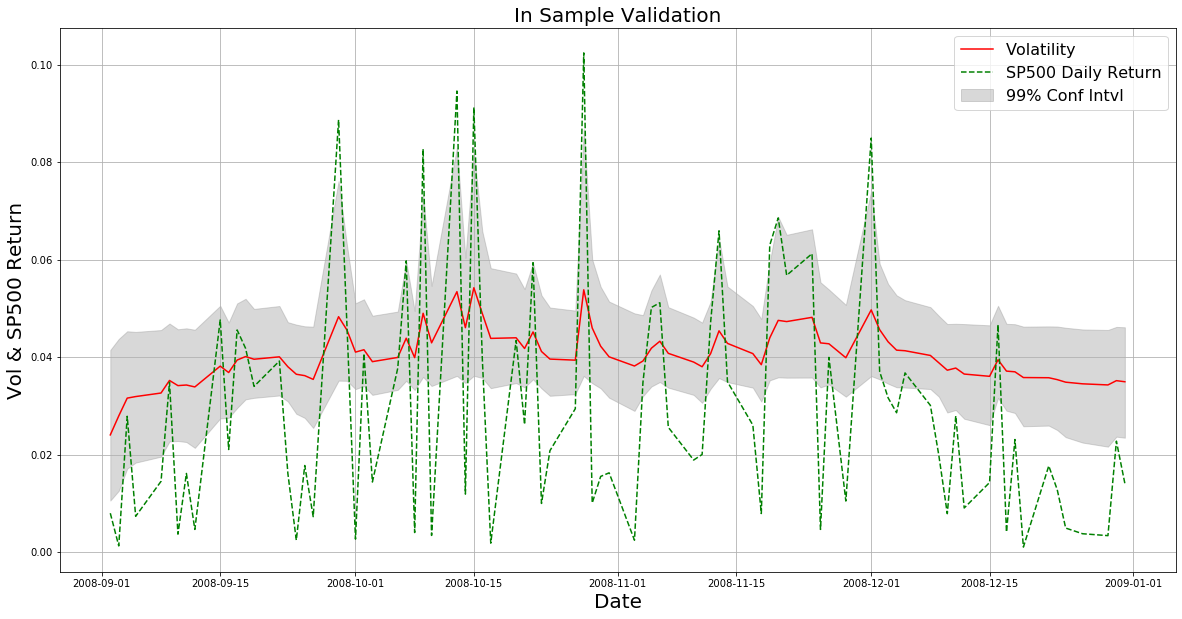

In [11]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.plot(obs.index, np.sqrt(vol_avg), color='red',  label='Volatility')
ax1.plot(obs.index, np.abs(obs), color='green', linestyle='--', label = 'SP500 Daily Return')
ax1.fill_between(obs.index, np.sqrt(down), np.sqrt(up), alpha=0.3, color='grey', label='99% Conf Intvl')
#ax1.plot(obs.index, vix, alpha=0.7, color='blue', label='Vix Index')
ax1.set_xlabel('Date', size=20)
ax1.set_ylabel('Vol & SP500 Return', size=20)
ax1.set_title('In Sample Validation', size=20)
plt.grid()

#ax2 = ax1.twinx()
#ax2.plot(vix.index, vix, alpha=0.7, color='blue', label='Vix Index')
#ax2.set_ylabel('VIX', size=12)

fig.legend(loc=1, prop={'size': 16}, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

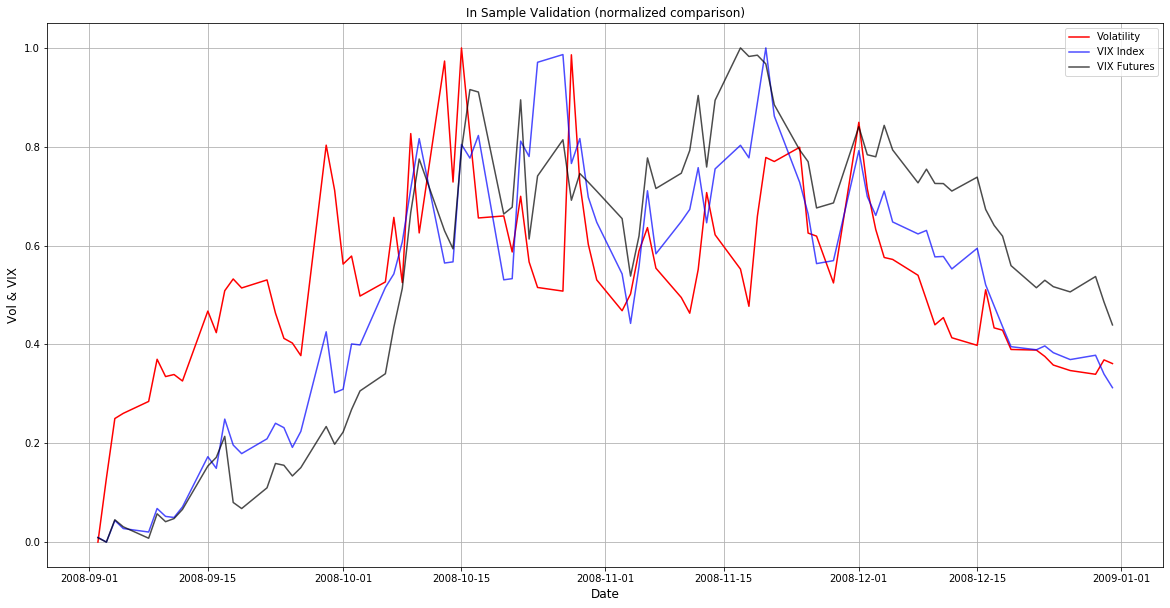

In [12]:
# compare historical volatility with VIX index, both values are normalized.

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.plot(obs.index, normalize(np.sqrt(vol_avg)), color='red', label='Volatility')
#ax1.plot(obs.index, normalize(obs), color='green', alpha=0.7, label = 'Absolute Daily Return')
#ax1.fill_between(obs.index, normalize(np.sqrt(down)), normalize(np.sqrt(up)), alpha=0.3, color='grey', label='99% Conf Intvl')
ax1.plot(obs.index, normalize(vix), alpha=0.7, color='blue', label='VIX Index')
ax1.plot(vix_f.index, normalize(vix_f), alpha=0.7, color='black', label='VIX Futures')
ax1.set_xlabel('Date', size=12)
ax1.set_ylabel('Vol & VIX', size=12)
ax1.set_title('In Sample Validation (normalized comparison)', size=12)

plt.grid()

#ax2 = ax1.twinx()
#ax2.plot(vix.index, vix, alpha=0.7, color='blue', label='Vix Index')
#ax2.set_ylabel('VIX', size=12)

fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

# Out of sample predictions

The predictions are all based on parameters from posterior of in-sample observations, once the market is closed, we have one observation of SP500 return and we can calculate the next day’s volatility, and rolling forward, we'll have a time series of future volatility for out of sample time steps, here for simplicity, I sample posterior only once using in sample observations, since the computation time is too long to sample iterativly rolling forward.

In [13]:
post['vol'] = [x for x in vol.iloc[-1]]
post['ret'] = obs[-1]

vol_pred = pd.DataFrame()
next_vol = list(map(lambda a0,a1,b1,vol,ret: a0 + a1*(ret**2) + b1*vol, 
                    post.a0, post.a1, post.b1, post.vol, post.ret)) 
vol_pred[holdout_obs.index[0]] = next_vol

for i in range(len(holdout_obs)-1):
    post.vol = next_vol
    post.ret = holdout_obs[i]
    next_vol = list(map(lambda a0,a1,b1,vol,ret: a0 + a1*(ret**2) + b1*vol, 
                    post.a0, post.a1, post.b1, post.vol, post.ret))
    vol_pred[holdout_obs.index[i+1]] = next_vol
    
down_pred = vol_pred.quantile(0.005, axis=0)
up_pred = vol_pred.quantile(0.995, axis=0)
vol_predavg = vol_pred.mean(axis=0)

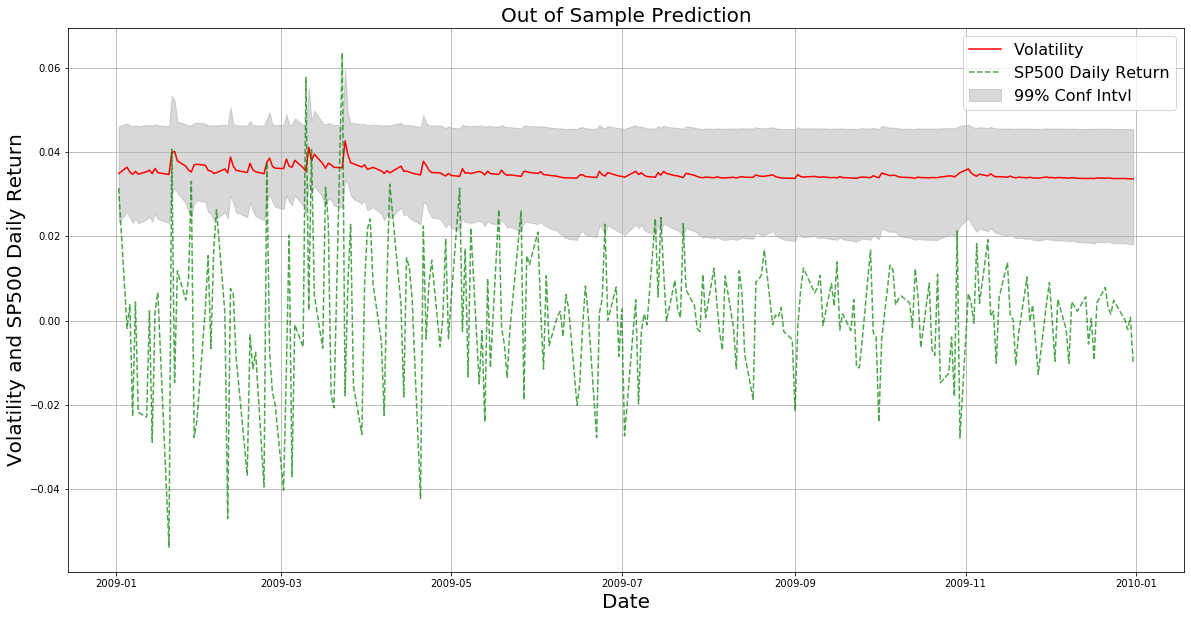

In [14]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.plot(vol_predavg.index, np.sqrt(vol_predavg), color='red', label='Volatility')
ax1.plot(holdout_obs.index, holdout_obs, linestyle='--', color='green', alpha=0.7, label = 'SP500 Daily Return')
ax1.fill_between(holdout_obs.index, np.sqrt(down_pred), np.sqrt(up_pred), alpha=0.3, color='grey', label='99% Conf Intvl')
ax1.set_xlabel('Date', size=20)
ax1.set_ylabel('Volatility and SP500 Daily Return', size=20)
ax1.set_title('Out of Sample Prediction', size=20)
plt.grid()

#ax2 = ax1.twinx()
#ax2.plot(holdout_vix.index, holdout_vix,  linestyle='--', color='blue', label='Vix Index')
#ax2.set_ylabel('VIX', size=20)

fig.legend(loc=1, prop={'size': 16}, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

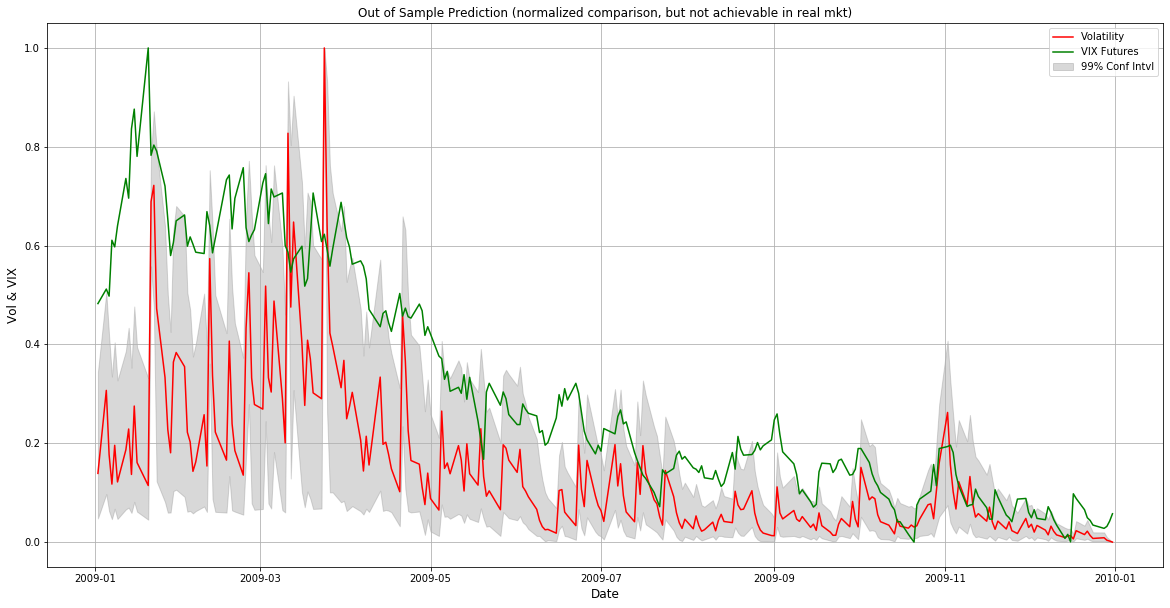

In [15]:
# comparison between volatility and VIX index, both are normalized but actually in real market,
# we cannot normalize them since we don't know the future values of volatility and VIX

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.plot(vol_predavg.index, normalize(np.sqrt(vol_predavg)), color='red', label='Volatility')
#ax1.plot(holdout_obs.index, holdout_obs, color='green', alpha=0.7, label = 'Absolute Daily Return')
ax1.fill_between(holdout_obs.index, normalize(np.sqrt(down_pred)), normalize(np.sqrt(up_pred)), alpha=0.3, color='grey', label='99% Conf Intvl')
#ax1.plot(holdout_vix.index, normalize(holdout_vix), alpha=0.7, color='blue', label='Vix Index')
ax1.plot(holdout_vix_f.index, normalize(holdout_vix_f), color='green', label='VIX Futures')
ax1.set_xlabel('Date', size=12)
ax1.set_ylabel('Vol & VIX', size=12)
ax1.set_title('Out of Sample Prediction (normalized comparison, but not achievable in real mkt)', size=12)
plt.grid()

fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

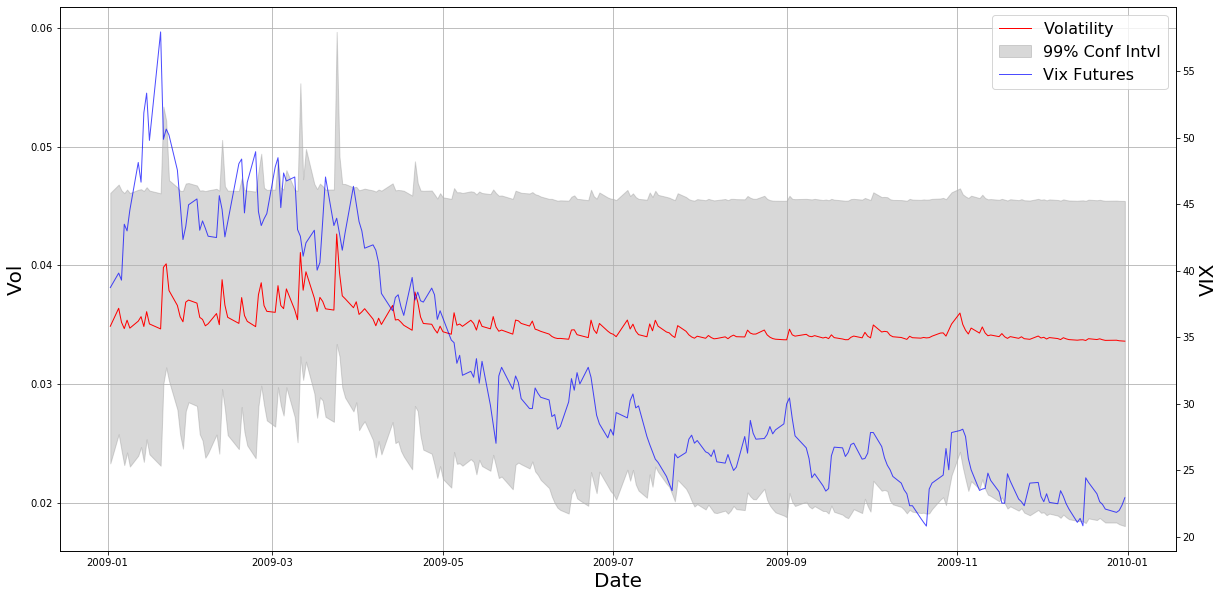

In [16]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.plot(vol_predavg.index, np.sqrt(vol_predavg), color='red', lw=1, label='Volatility')
#ax1.plot(obs.index, obs, color='green', linestyle='--', label = 'SP500 Daily Return')
ax1.fill_between(vol_predavg.index, np.sqrt(down_pred), np.sqrt(up_pred), alpha=0.3, color='grey', label='99% Conf Intvl')
#ax1.plot(obs.index, vix, alpha=0.7, color='blue', label='Vix Index')
ax1.set_xlabel('Date', size=20)
ax1.set_ylabel('Vol', size=20)
#ax1.set_title('In Sample Validation', size=20)
plt.grid()

ax2 = ax1.twinx()
ax2.plot(holdout_vix_f[:vol_predavg.index[-1]].index, holdout_vix_f[:vol_predavg.index[-1]], 
         lw=1, alpha=0.7, color='blue', label='Vix Futures')
ax2.set_ylabel('VIX', size=20)

fig.legend(loc=1, prop={'size': 16}, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

# Statistical Patterns

In [17]:
x = vol_avg
y = vix_f
for i in x.index:
    if i not in y.index:
        x = x.drop(index=i)
        
for j in y.index:
    if j not in x.index:
        y = y.drop(index=j)
        
x.size, y.size

(85, 85)

/Users/jinxiwen/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


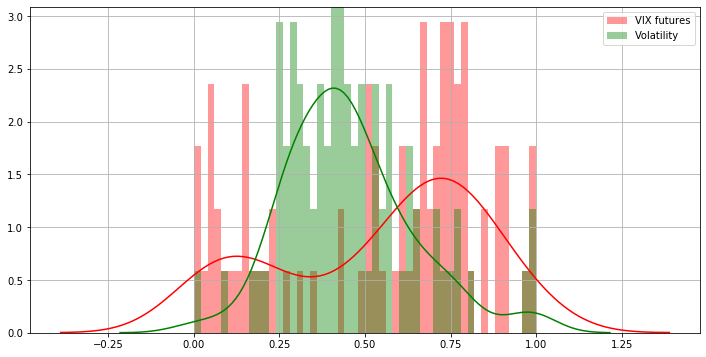

In [18]:
plt.figure(figsize=(12,6))
sns.distplot(normalize(y), bins=50, color='red', label='VIX futures')
sns.distplot(normalize(x), bins=50, color='green', label='Volatility')
plt.legend(loc='best')
plt.grid()

/Users/jinxiwen/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:214: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


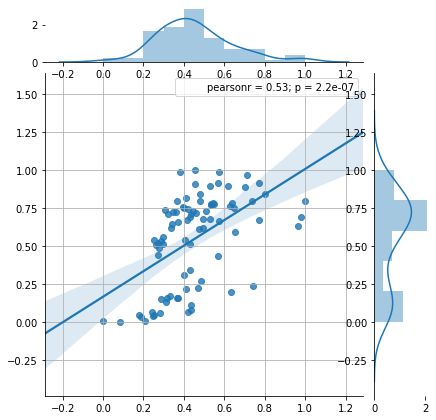

In [19]:
sns.jointplot(x=normalize(x), y=normalize(y), kind="reg")
plt.grid()
plt.show()

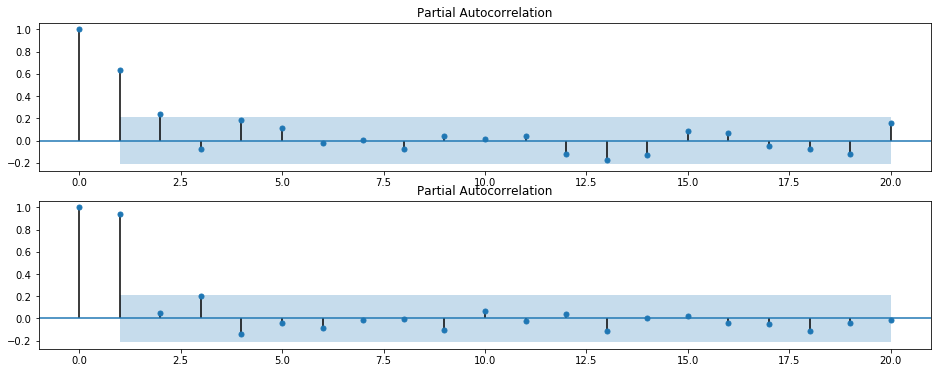

In [576]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(2,1,1)
plot_pacf(vol_avg, lags=20, alpha=0.05, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
plot_pacf(vix_f, lags=20, alpha=0.05, ax=ax2)
plt.show()

# GP fit on [volatility]

In [116]:
kernel = RationalQuadratic() +\
         WhiteKernel(noise_level=1e-10, noise_level_bounds=[1e-30, 1e-20]) +\
         ExpSineSquared() 
         #RationalQuadratic() +\
         #Matern()
         #DotProduct() +\
         #RBF() +\
        
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer= 40)
gp.fit(np.array(vol_avg).reshape(-1,1), np.array(vix_f).reshape(-1,1))

/Users/jinxiwen/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -4.37421485e+01,   2.54884795e+09,  -4.78667966e-08,
         1.95679144e-01,   1.95679144e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-10) + ExpSineSquared(length_scale=1, periodicity=1),
             n_restarts_optimizer=40, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [117]:
y_pred, sigma = gp.predict(np.array(vol_predavg).reshape(-1,1), return_std=True)
up = y_pred.flatten() - 2 * sigma  # 95% confident interval 
down = y_pred.flatten() + 2 * sigma

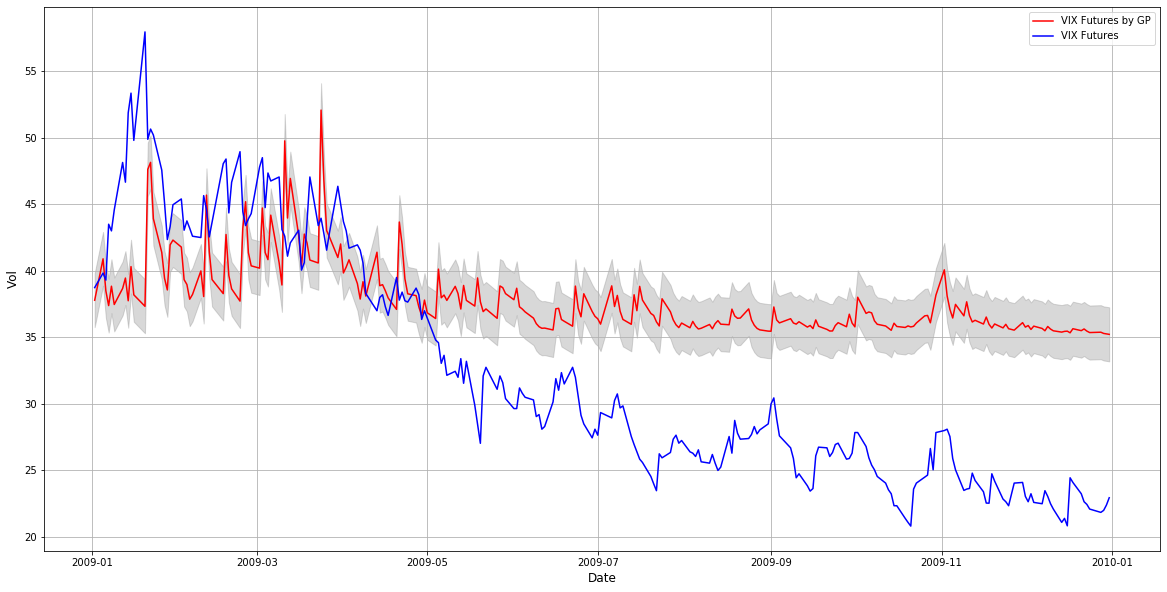

In [118]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.plot(holdout_vix_f.index, y_pred.flatten(), color='red', label='VIX Futures by GP')
ax1.plot(holdout_vix_f.index, holdout_vix_f, color='blue', label='VIX Futures')
ax1.fill_between(holdout_vix_f.index, up, down, color = 'grey', alpha=0.3)
ax1.set_xlabel('Date', size=12)
ax1.set_ylabel('Vol', size=12)
plt.grid()

#ax2 = ax1.twinx()
#ax2.plot(holdout_vix_f.index, holdout_vix_f, color='blue', label='VIX Futures')
#ax2.set_ylabel('VIX futures', size=12)

fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

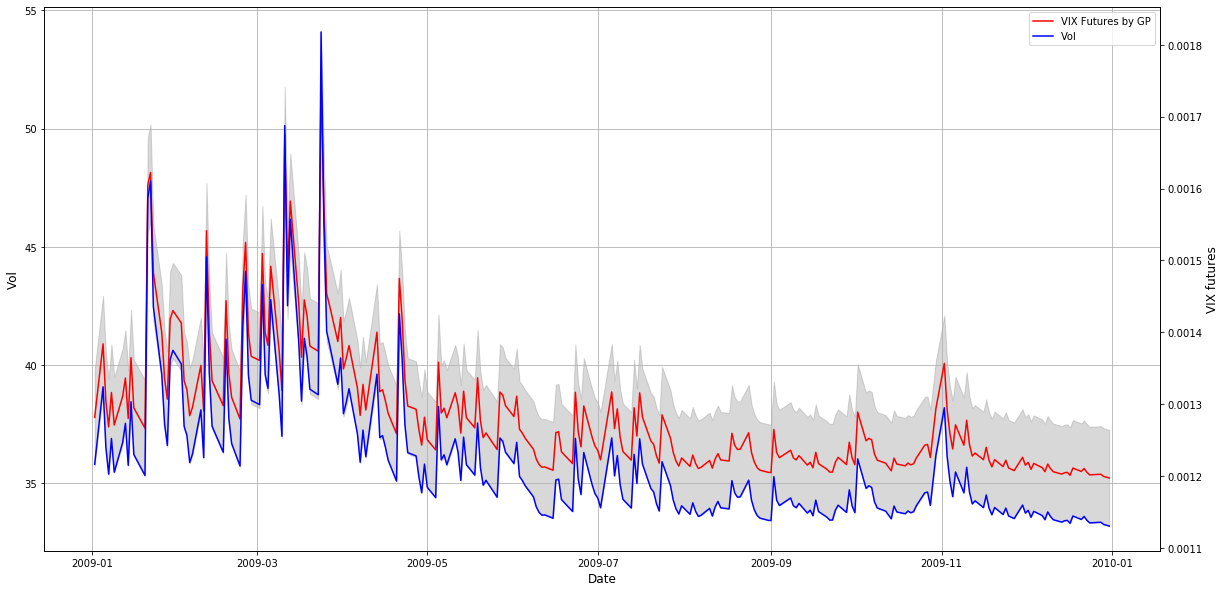

In [119]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.plot(holdout_vix_f.index, y_pred.flatten(), color='red', label='VIX Futures by GP')
ax1.fill_between(holdout_vix_f.index, up, down, color = 'grey', alpha=0.3)
ax1.set_xlabel('Date', size=12)
ax1.set_ylabel('Vol', size=12)
plt.grid()

ax2 = ax1.twinx()
ax2.plot(vol_predavg.index, vol_predavg, color='blue', label='Vol')
ax2.set_ylabel('VIX futures', size=12)

fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

* it basically repeats the pattern of volatility

# GP fit on [one day lag vix futures]

In [156]:
lag = 1
input_1d = pd.DataFrame(data=np.c_[vix_f.shift(lag)[lag:]], 
            index=vix_f.index[lag:], columns=['lag_vixf'])


gp = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer= 50)
gp.fit(np.array(input_1d), np.array(vix_f[lag:]).reshape(-1,1))

/Users/jinxiwen/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-389.94913052,  465.55663182,   -0.98009945,  250.66303894,
        250.67187357]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jinxiwen/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -8.96296665e-02,   1.01473033e+04,  -1.35469011e-02,
         1.29912843e+07,  -2.99057517e+12]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jinxiwen/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -1.13225110e+05,   2.65268763e+04,  -1.93391106e-05,
      

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-10) + ExpSineSquared(length_scale=1, periodicity=1),
             n_restarts_optimizer=50, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [157]:
test_1d = pd.DataFrame(data=np.c_[pd.concat([vix_f.iloc[-lag:], holdout_vix_f]).shift(1)[lag:]], 
             index = holdout_vix_f.index, columns=['lag_vixf'])

y_pred_vix1, sigma = gp.predict(np.array(test_1d), return_std=True)
up = y_pred_vix1.flatten() - 2 * sigma  # 95% confident interval 
down = y_pred_vix1.flatten() + 2 * sigma

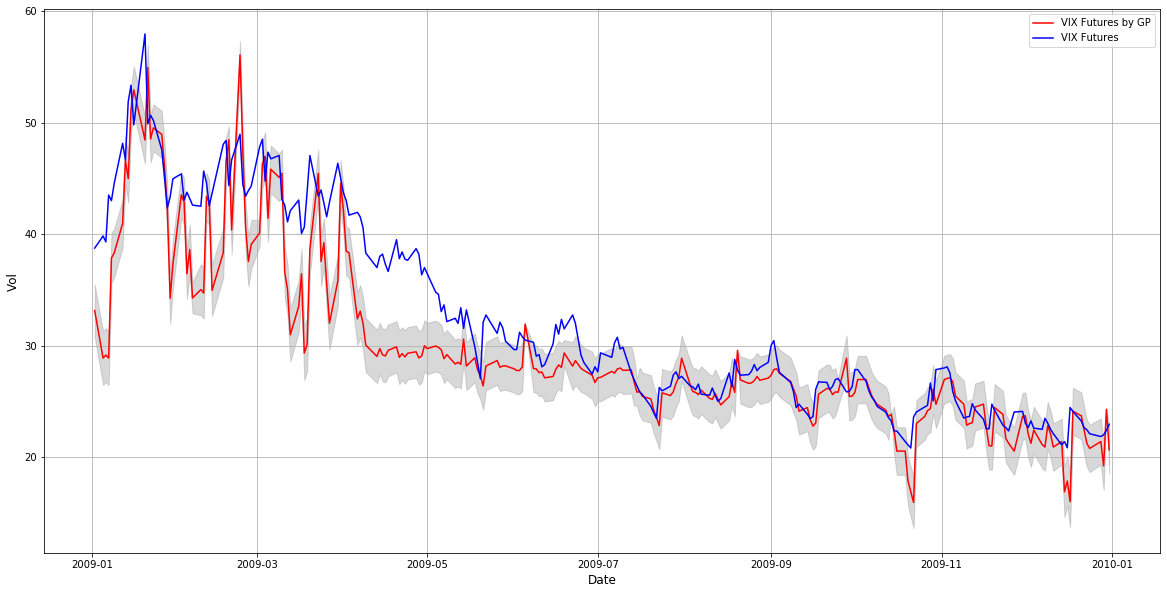

In [158]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.plot(holdout_vix_f.index, y_pred_vix1.flatten(), color='red', label='VIX Futures by GP')
ax1.fill_between(holdout_vix_f.index, up, down, color = 'grey', alpha=0.3)
ax1.plot(holdout_vix_f.index, holdout_vix_f, color='blue', label='VIX Futures')
ax1.set_xlabel('Date', size=12)
#ax1.set_xlim('2009-01-01', '2009-03-01')
ax1.set_ylabel('Vol', size=12)
plt.grid()

#ax2 = ax1.twinx()
#ax2.plot(holdout_vix_f.index, holdout_vix_f, color='blue', label='VIX Futures')
#ax2.set_ylabel('VIX futures', size=12)

fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

* very unstable, it has different results every time we refit.
* there exists 1 day lag, auto-correlation

# GP fit on [one day lag vix futures, volatility]

In [815]:
input_2d = pd.DataFrame(data=np.c_[vix_f.shift(lag)[lag:], vol_avg[lag:]], 
                     index=vix_f.index[lag:], columns=['lag_vixf', 'vol'])

    
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer= 50)
gp.fit(np.array(input_2d), np.array(vix_f[lag:]).reshape(-1,1))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-10) + ExpSineSquared(length_scale=1, periodicity=1),
             n_restarts_optimizer=50, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [816]:
test_2d = pd.DataFrame(data=np.c_[pd.concat([vix_f[-lag:], holdout_vix_f]).shift(lag)[lag:], vol_predavg], 
             index = holdout_vix_f.index, columns=['lag_vixf', 'vol'])

y_pred, sigma = gp.predict(np.array(test_2d), return_std=True)
up = y_pred.flatten() - 2 * sigma  # 95% confident interval 
down = y_pred.flatten() + 2 * sigma

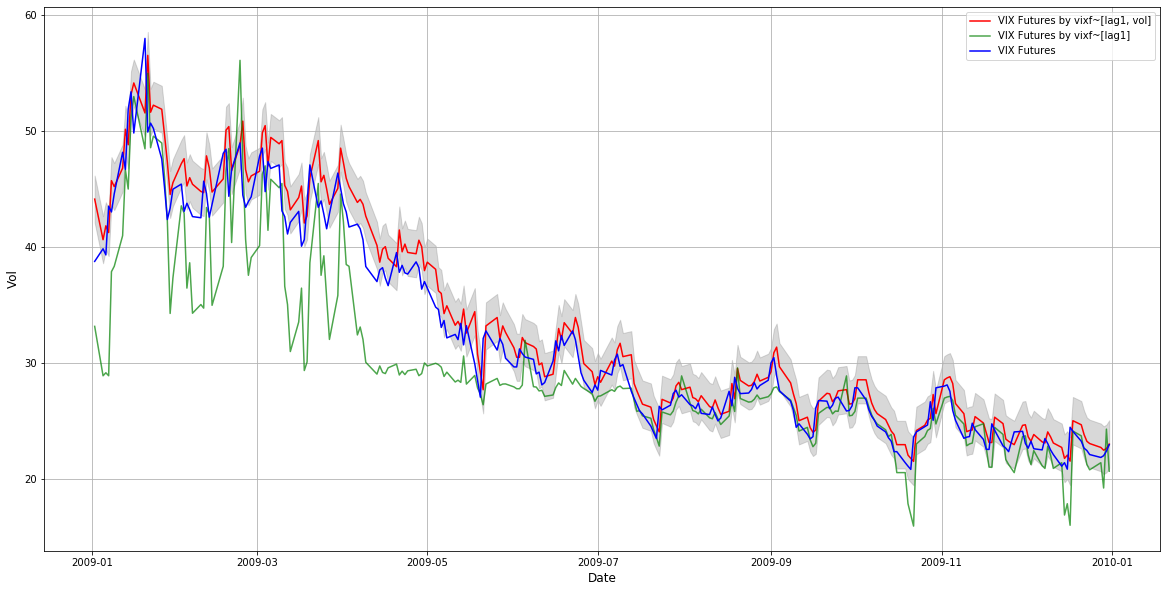

In [817]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.plot(holdout_vix_f.index, y_pred.flatten(), color='red', label='VIX Futures by vixf~[lag1, vol]')
ax1.plot(holdout_vix_f.index, y_pred_vix1.flatten(), color='green',alpha=0.7, label='VIX Futures by vixf~[lag1]')
ax1.fill_between(holdout_vix_f.index, up, down, color = 'grey', alpha=0.3)
ax1.plot(holdout_vix_f.index, holdout_vix_f, color='blue', label='VIX Futures')
ax1.set_xlabel('Date', size=12)
ax1.set_ylabel('Vol', size=12)
plt.grid()

#ax2 = ax1.twinx()
#ax2.plot(holdout_vix_f.index, holdout_vix_f, color='blue', label='VIX Futures')
#ax2.set_ylabel('VIX futures', size=12)

fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

* predictions are much better
* very stable results, but still, there exists 1 period lag auto-correlation

# Fit 1st order difference ~ [lag1, volatility] to reduce auto-correlation

In [832]:
# [diff_vix_f, vol] for 1st order diff fit.
#x_train = pd.DataFrame(MinMaxScaler().fit_transform(np.c_[vix_f.diff(lag)[lag:], vol_avg[lag:]]), 
 #            index = vix_f.index[lag:], columns=['diff_vixf', 'diff_vol'])

#a = MinMaxScaler().fit_transform(np.array([vol_predavg]).reshape(-1,1))
#b = MinMaxScaler().fit_transform(np.concatenate([vix_f[-lag*2:], holdout_vix_f[:-lag]]).reshape(-1,1))
#b = b[lag:] - b[:-lag]
#x_test = pd.DataFrame([b.flatten(), a.flatten()]).T
#x_test.columns = ['diff_vixf', 'diff_vol']
#x_test = x_test.set_index(holdout_vix_f.index)
    
    
# 1st order difference fit on [lag1, volatility] 
x_train = MinMaxScaler().fit_transform(np.array(input_2d))
y_train = MinMaxScaler().fit_transform(np.array(vix_f.diff(lag)[lag:]).reshape(-1,1))

x_test = MinMaxScaler().fit_transform(np.array(test_2d))
y_test = pd.concat([vix_f[-lag:], holdout_vix_f]).diff(lag)[lag:]
y_test = MinMaxScaler().fit_transform(np.array(y_test).reshape(-1,1))

gp = gaussian_process.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer= 50)
gp.fit(x_train, y_train)

/Users/jinxiwen/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  3.03764546e-16,  -1.31739664e-07,   4.78886550e-21,
        -7.88865487e-01,   2.33299312e+08]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/jinxiwen/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  3.35162835e-15,  -1.21895771e-06,   2.15864525e-24,
        -2.07483103e-03,  -2.24243913e+06]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 33, 'nit': 1, 'warnflag': 2}
  " state: %s" % convergence_dict)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RationalQuadratic(alpha=1, length_scale=1) + WhiteKernel(noise_level=1e-10) + ExpSineSquared(length_scale=1, periodicity=1),
             n_restarts_optimizer=50, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [833]:
y_pred, sigma = gp.predict(x_test, return_std=True)
up = y_pred.flatten() - 2 * sigma  # 95% confident interval 
down = y_pred.flatten() + 2 * sigma

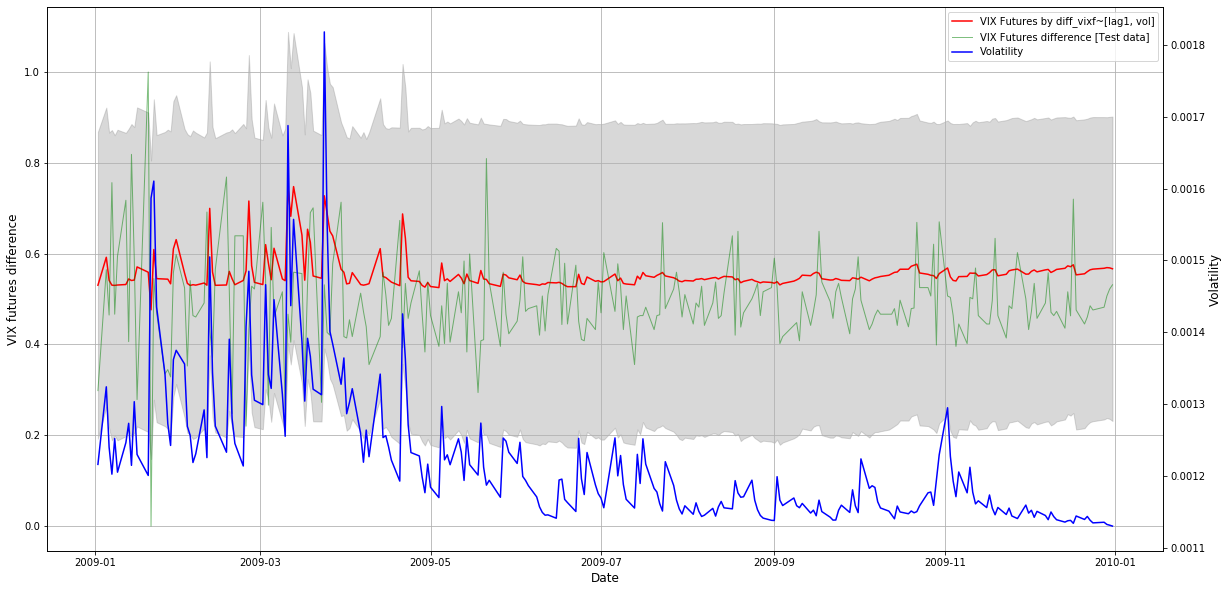

In [846]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.plot(holdout_vix_f.index, y_pred, lw=1.5, color='red', label='VIX Futures by diff_vixf~[lag1, vol]')
ax1.plot(holdout_vix_f.index, y_test, lw=1, color='green', alpha=0.5, label='VIX Futures difference [Test data]')
ax1.fill_between(holdout_vix_f.index, up, down, color = 'grey', alpha=0.3)
ax1.set_xlabel('Date', size=12)
#ax1.set_xlim('2009-01-01', '2009-09-01')
ax1.set_ylabel('VIX futures difference', size=12)
plt.grid()

ax2 = ax1.twinx()
ax2.plot(holdout_vix_f.index, test_2d.vol, lw=1.5, color='blue', label='Volatility')

ax2.set_ylabel('Volatility', size=12)

fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

* basically it follows the trend of volatility, which means 1 order difference sucessfully reduced auto-correlation, but instead, our model learns from the volatility most of the time.
* above works indicate that we haven't found the features/features combination that really valuable to VIX futures prediction, more digging is needed.

# Optimization

In [27]:
#params = [wid, qtl, scaler_u, scaler_l]
def obj_func(params):
    print(params)
    upper = vol_avg.rolling(window=int(params[0])).quantile(min(params[1], 1.))*params[2]
    upper = upper[~upper.isna()]

    lower = vol_avg.rolling(window=int(params[0])).min()*params[3]
    lower = lower[~lower.isna()]
    
    long, short, close= signals_3(lower, upper, vol_avg[int(params[0])-1:])
    bps, _, _ = profit(long, short, close, vix_f[int(params[0])-1:], 0.001)
    #print(-bps, params)
    return -bps

In [18]:
def loc_min(fn):
    eps = 1e-3
    rng = [[a,b,c,d] for a in np.arange(5,100,20) \
           for b in np.arange(0.1,1.,0.2) \
           for c in np.arange(1.,2.,0.2)\
           for d in np.arange(1.+eps,1.1,0.2)]
    bps = [x for x in map(fn, rng)]
    return rng[bps.index(min(bps))], bps

In [25]:
initial_guess, bps = loc_min(obj_func)

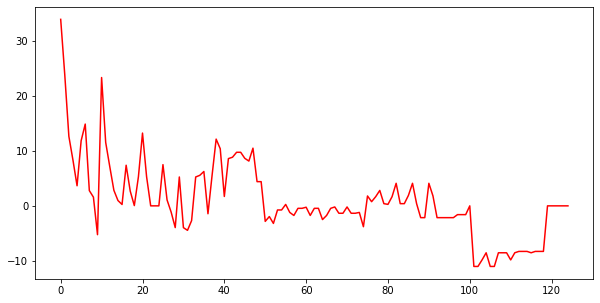

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(bps, color='red')
plt.show()

In [31]:
eps = 1e-4
bounds = [(5., 100.), (0.1, 1.), (1., 2.), (1.+eps, 1.1)]
#initial_guess = [15, 0.5, 1.05, 1.01]

cons = []
for factor in range(len(bounds)):
    lower, upper = bounds[factor]
    l = {'type': 'ineq',
         'fun': lambda x, lb=lower, i=factor: x[i] - lb}
    u = {'type': 'ineq',
         'fun': lambda x, ub=upper, i=factor: ub - x[i]}
    cons.append(l)
    cons.append(u)
    

#opt_params = minimize(obj_func, initial_guess, bounds=bounds, method='TNC', options={'maxiter':10000 , 'disp': True})
opt_params = minimize(obj_func, initial_guess, method='COBYLA', constraints=cons, 
                      options={'eps':0.02, 'tol':1e-10, 'maxiter':1000 , 'disp': True})

[ 85.      0.1     1.2     1.001]
[ 86.      0.1     1.2     1.001]
[ 86.      1.1     1.2     1.001]
[ 86.      0.1     2.2     1.001]
[ 86.      0.1     1.2     2.001]
[ 86.97979548   0.1          1.           1.0001    ]
[ 86.45825669   0.1          1.           1.0001    ]
[ 85.75074045   0.1          1.18079413   1.0001    ]
[  8.60000000e+01  -2.50000000e-02   1.20000000e+00   1.00100000e+00]


/Users/jinxiwen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: OptimizeWarning: Unknown solver options: eps


ValueError: quantile value -0.024999999999999994 not in [0, 1]

In [23]:
opt_params, initial_guess

NameError: name 'opt_params' is not defined

In [24]:
initial_guess

[85, 0.10000000000000001, 1.2, 1.0009999999999999]

# Generate trading signals

In [32]:
# controling parameters of calculating levels.
# params = [wid, qtl, scaler_u, scaler_l]
scaler = initial_guess[2]
lower_scaler = initial_guess[3]
wid = int(initial_guess[0])
qtl = initial_guess[1]

# upper level of volatility, using rolling quantiles
upper = pd.concat([vol_avg[-wid+1:], vol_predavg]).rolling(window=wid).quantile(qtl)*scaler
upper = upper[~upper.isna()]

# lower level of volatility, using rolling min
lower = pd.concat([vol_avg[-wid+1:], vol_predavg]).rolling(window=wid).min()*(lower_scaler)
lower = lower[~lower.isna()]

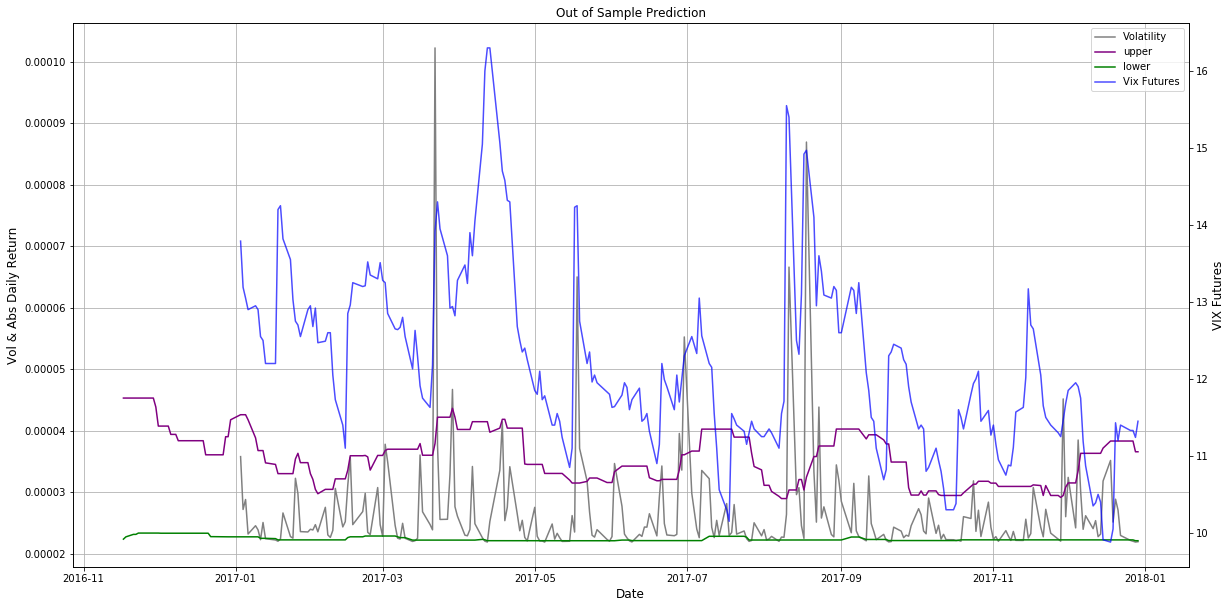

In [48]:
# visualze upper and lower levels
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.plot(vol_predavg.index, vol_predavg, color='grey', label='Volatility')
#ax1.plot(vol_predavg.index, (upper+lower)/2., color='black', alpha=0.7, label = 'mid')
ax1.plot(upper.index, upper, color='purple', label='upper')
#ax1.plot(MA.index, np.sqrt(MA), color='black', label='MA')
ax1.plot(lower.index, lower, color='green', label='lower')
#ax1.fill_between(vol_predavg.index, np.sqrt(down_pred), np.sqrt(up_pred), alpha=0.3, color='grey', label='99% Conf Intvl')
ax1.set_xlabel('Date', size=12)
ax1.set_ylabel('Vol & Abs Daily Return', size=12)
ax1.set_title('Out of Sample Prediction', size=12)
#ax1.set_xlim('2014-06-01', '2014-07-01')
plt.grid()

ax2 = ax1.twinx()
ax2.plot(holdout_vix_f.index, holdout_vix_f, alpha=0.7, color='blue', label='Vix Futures')
ax2.set_ylabel('VIX Futures', size=12)

fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

In [41]:
def calc_gap(train, test, params):
    # params = [rolling_wid, qtl, scaler_u, scaler_l, gap_wid]
    # concat_window should be the (maximum btw rolling_wid & gap_wid) + rolling_wid, 
    # but no larger than len(train)
    if len(train) < max(int(params[0]), int(params[4])) + int(params[0]):
        raise Exception('Training size less than concat_window, increase training size.')
    
    concat_wid = max(int(params[0]), int(params[4])) + int(params[0])
    beg = test.index[0]
    
    # upper level of volatility, using rolling quantiles
    upper = pd.concat([train[-concat_wid+1:], test]).\
                        rolling(window=int(params[0])).quantile(params[1])*params[2]

    # lower level of volatility, using rolling min
    lower = pd.concat([train[-concat_wid+1:], test]).\
                        rolling(window=params[0]).min()*(params[3])
    
    # difference btw upper & lower, long if gap increase, short otherwise
    gap = (upper-lower).rolling(window=int(params[4])).mean()
    return gap[beg:], upper, lower
    


In [47]:
# params = [rolling_wid, qtl, scaler_u, scaler_l, gap_wid]
gap, upper, lower=calc_gap(vol_avg, vol_predavg, [20, 0.8, 1.2, 1.01, 30])

<IPython.core.display.Javascript object>


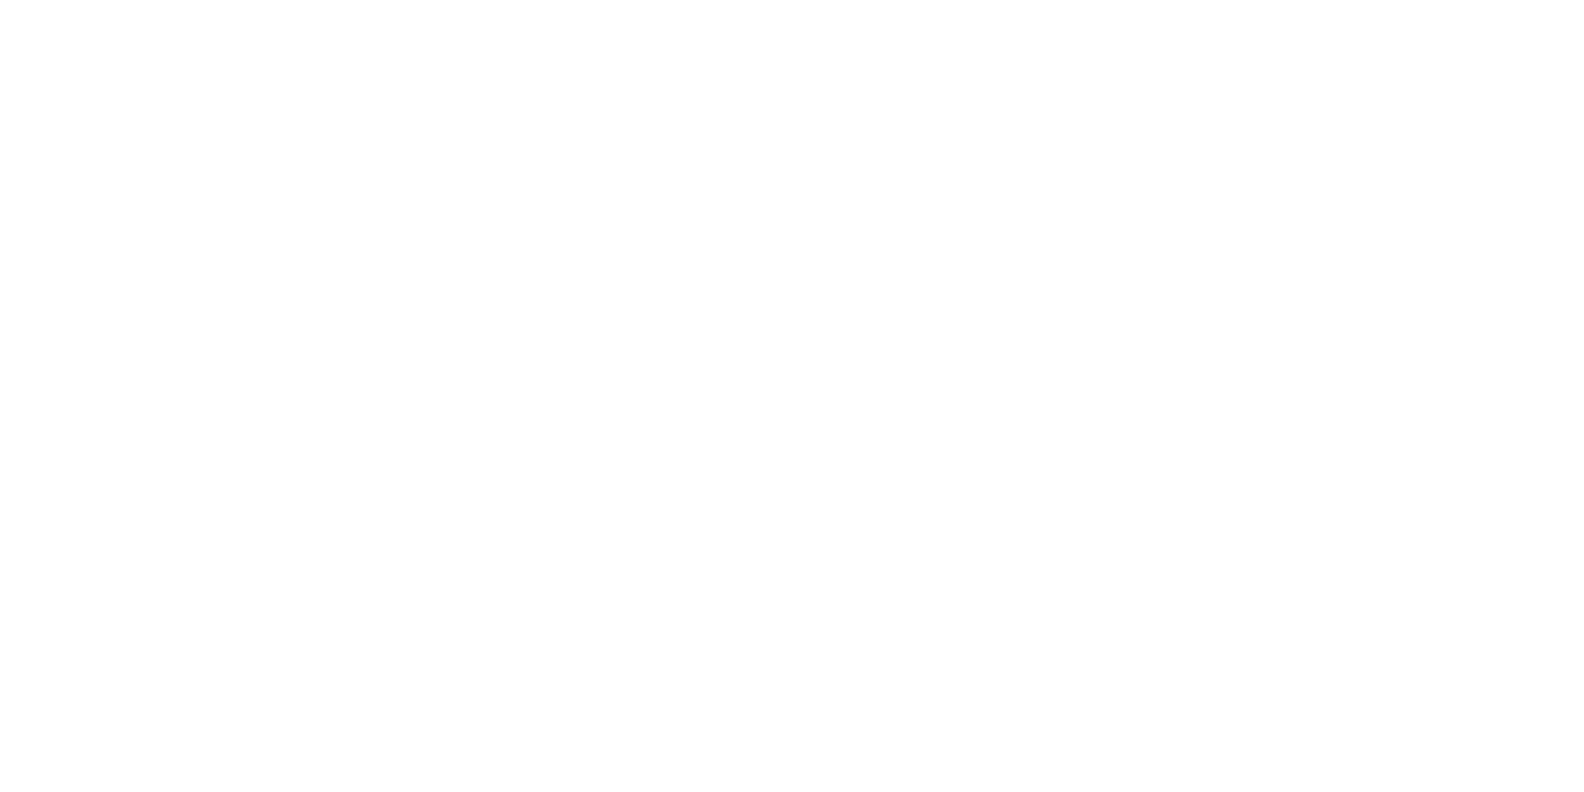

<IPython.core.display.Javascript object>


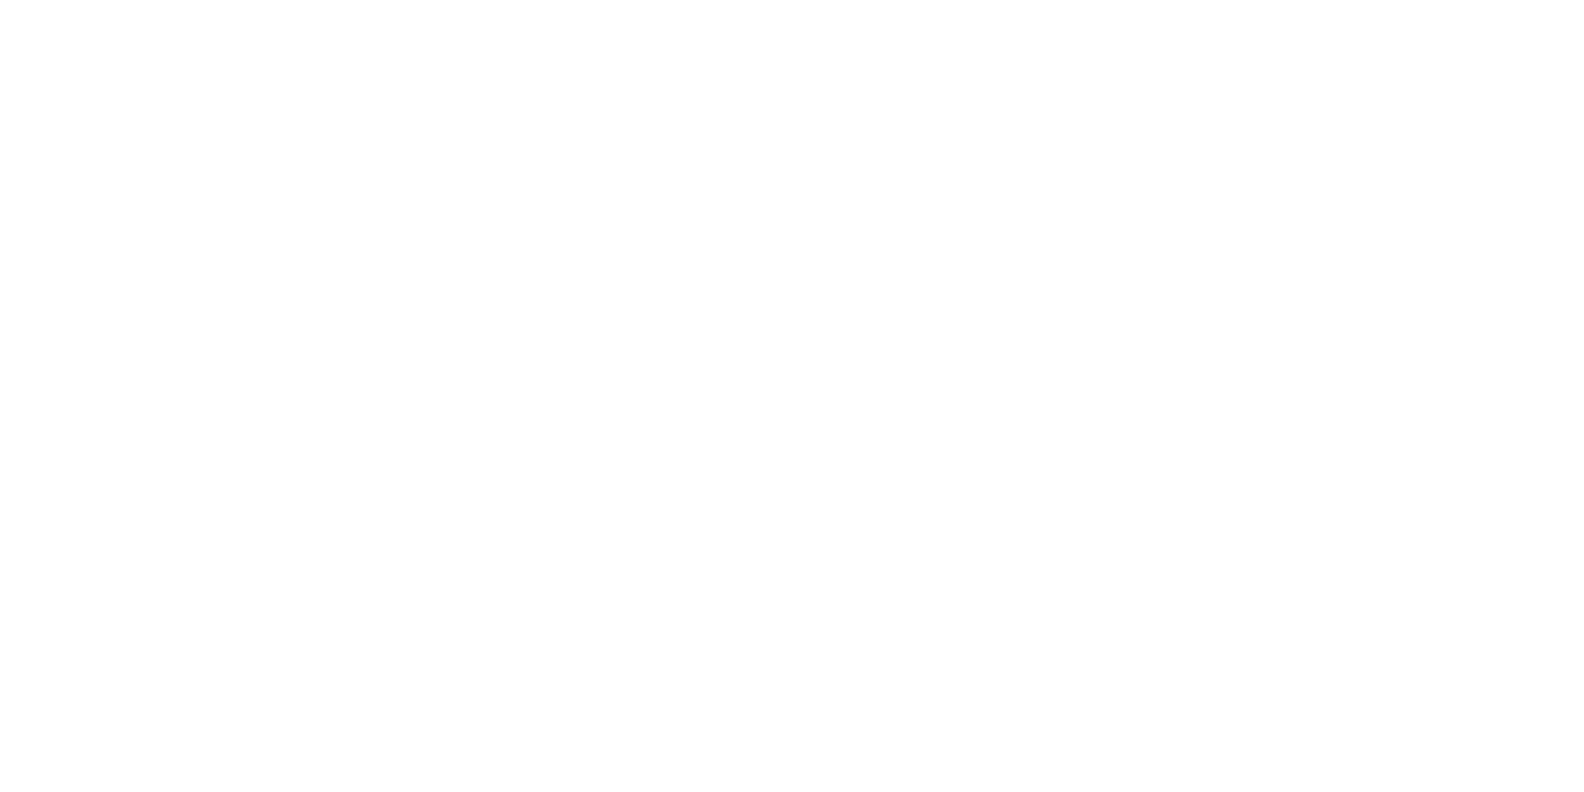

Traceback (most recent call last):
  File "/Users/jinxiwen/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/Users/jinxiwen/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [51]:
%matplotlib notebook
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.grid()
ax2 = ax1.twinx()

 
def animate(i):
    data = gap[:i]
    vf = holdout_vix_f[:i]
    #ax2.plot(vf.index, vf, alpha=0.7, lw=1, color='blue', label='Vix Futures')
    ax1.plot(data.index, data, alpha=0.7, lw=1, color='red', label='gap')
    

anim = animation.FuncAnimation(fig, animate, frames=len(holdout_vix_f), interval=10, repeat=False)
    
plt.show()

In [27]:
def signal_4(train, test, vixf, params, stoploss=0.025, stopgain=0.30, fee=0.0005):
    gap = calc_gap(train, test, params)
    diff = gap.diff()
    long, short, close = [],[],[]
    pos = 0
    holder = deque([])
    check = []
    for i in range(len(gap)):
        if diff[i] > 0 and pos != 1:
            long.append(gap.index[i-1])
            pos = 1
            holder.append(vixf[i-1]*(1+fee))
            print('long: ', long[-1], vixf[long[-1]])
        elif diff[i] < 0 and pos != -1:
            short.append(gap.index[i-1])
            pos = -1
            holder.append(vixf[i-1]*(1+fee))
            print('short: ', short[-1], vixf[short[-1]])
        
        if len(holder)>0:
            holder.append(vixf[i])
            bps = pos*(holder[-1]-holder[0])/holder[0]
            check.append(bps)
        #holder.pop()
        
            if -10. < bps < -np.abs(stoploss) or stopgain < bps < 10.:
                close.append(gap.index[i-1])
                print('close: ', close[-1], vixf[close[-1]])
                #print('bps: ', bps)
                holder.clear()

        
                
    return long, short, close, gap, check

In [53]:
13.70*0.8

10.96

In [40]:
(14.05-13.79)/13.79

0.018854242204496125

In [38]:
### generate long and short trading signals
params = [30, 0.6, 1.2, 1.01, 60]
long, short, close, gap, check = signal_4(vol_avg, vol_predavg, holdout_vix_f, params, stoploss=0.05, stopgain=0.2)

short:  2017-01-03 00:00:00 13.79
close:  2017-04-07 00:00:00 14.05
long:  2017-04-19 00:00:00 14.58
short:  2017-04-21 00:00:00 14.3
long:  2017-04-24 00:00:00 12.68
close:  2017-04-24 00:00:00 12.68
short:  2017-05-12 00:00:00 11.24
long:  2017-05-15 00:00:00 10.85
close:  2017-05-16 00:00:00 11.1
short:  2017-05-26 00:00:00 11.95
close:  2017-07-05 00:00:00 12.33
long:  2017-08-23 00:00:00 13.6
close:  2017-08-30 00:00:00 13.15
short:  2017-10-03 00:00:00 11.4
close:  2017-10-24 00:00:00 11.94
long:  2017-10-30 00:00:00 11.59
short:  2017-11-01 00:00:00 11.4
close:  2017-11-14 00:00:00 12.02
long:  2017-12-19 00:00:00 10.05


In [32]:
def profit(long, short, close, VIX_Futures_test, fee=0.):
    '''
    calculate the cumulated profit generated by trading signals
    long: trading signals of taking long position
    short: trading signals of taking short position
    VIX_Futures_test: out of sample data to which the signals are applied
    fee: approximate fee rate applied to each trade
    '''
    
    position_l = pd.DataFrame(VIX_Futures_test[long])
    position_l['pos'] = 1

    position_s = pd.DataFrame(VIX_Futures_test[short])
    position_s['pos'] = -1
    
    position_c = pd.DataFrame(VIX_Futures_test[close])
    position_c['pos'] = 0
    
    trades = pd.concat([position_l, position_s, position_c]).sort_index()
    bps = -fee
    pnl = [bps]
    price = trades.Close[0]
    pst = trades.pos[0]
    for i in range(1, len(trades.index[1:])):
        if pst != 0:
            bps += (trades.Close.iloc[i] - price)*pst*(1-fee)
            pnl.append(bps)
            price = trades.Close.iloc[i]
            pst = trades.pos.iloc[i]
        else: 
            bps -= np.abs(trades.Close.iloc[i] - price)*(1-fee)
            pnl.append(bps)
            price = trades.Close.iloc[min(i+1, len(VIX_Futures_test)-1)]
            pst = trades.pos.iloc[min(i+1, len(VIX_Futures_test)-1)]
        
    return bps, pnl, trades

In [243]:
book

,Close,pos
Trade_Date,,
2016-01-04,19.80,1
2016-01-14,23.55,0
2016-03-08,19.65,-1
2016-04-18,13.83,0
2016-07-12,14.30,1
2016-07-14,14.05,0
2016-08-09,12.40,-1
2016-08-09,12.40,0
2016-09-26,16.28,0


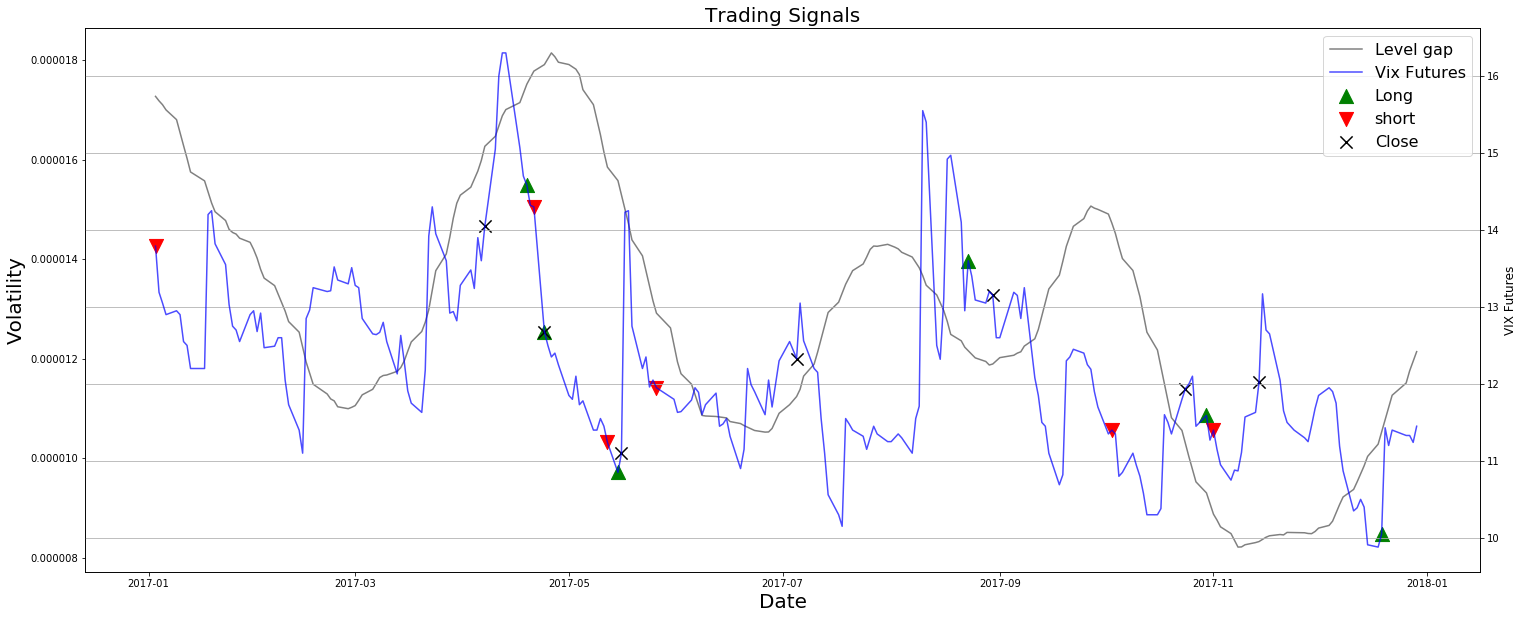

In [52]:
# scatter signals on VIX index
%matplotlib inline
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(111)
ax1.plot(gap.index, gap, color='grey', label='Level gap')
#ax1.plot(upper.index, np.sqrt(upper), color='green', label='upper')
#ax1.plot(lower.index, np.sqrt(lower), color='red', label='lower')
#ax1.set_xlim('2014-06-01', '2014-09-01')

ax1.set_xlabel('Date', size=20)
ax1.set_ylabel('Volatility', size=20)
ax1.set_title('Trading Signals', size=20)

ax2 = ax1.twinx()
ax2.plot(holdout_vix_f.index, holdout_vix_f, alpha=0.7, color='blue', label='Vix Futures')
ax2.scatter(long, holdout_vix_f[long], color='green', marker='^', s=200, label='Long')
ax2.scatter(short, holdout_vix_f[short], color='red', marker='v', s=200, label='short')
ax2.scatter(close, holdout_vix_f[close], color='black', marker='x', s=150, label='Close')
ax2.set_ylabel('VIX Futures', size=12)
#ax2.set_xlim('2014-09-01', '2015-01-01')

plt.grid()
fig.legend(loc=1, prop={'size': 16}, bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

In [36]:
# calculate profit and loss, in the unit points of VIX index

bps, pnl, book= profit(long, short, close, holdout_vix_f, 0.0005)
print('The profit is:', bps, 'VIX futures unit points.')

The profit is: -7.846575 VIX futures unit points.


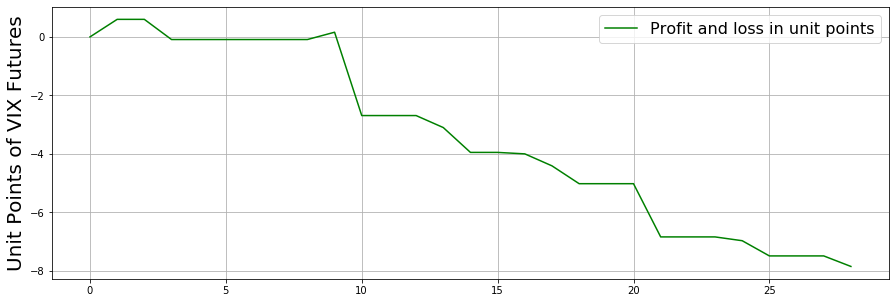

In [37]:
# plot profit and loss for out of sample time steps

plt.figure(figsize=(15,5))
plt.plot(pnl, color='green', label='Profit and loss in unit points')
plt.legend(loc='best', prop={'size': 16})
plt.ylabel('Unit Points of VIX Futures', size=20)
plt.grid()
plt.show()

# Thoughts & Questions

* I use Sequential Monte Carlo because this happened to be a project in class, but if I just use a point estimate out of posterior distribution, why bother use such complicated algorithm instead of just solving GARCH regression, perhaps a future work would be comparing the results of SMC and GARCH regression.


* Regardless of SMC algorithm for solving Bayesian, whether this is a possible direction to go for developing trading strategies on VIX futures? Since VIX index is constructed based on options which reflects the market perspectives regarding the future volatility, whereas we can predict volatility for just one step ahead. 


* On the other hand, both VIX futures and rolling forward prediction of volatility present clustering property, perhaps this is some property we can take advantage of.


* Since the controling parameters for calculating price levels are critical to the strategy performance, I'm thinking optimize them rolling forward within a certain time window, but how to prevent overfitting?


# Possible further works

* Sample posteriors rolling forward within a certian time window, instead of using in-sample data just once, see if results improves.


* Optimize controling parameters, i.e. 'scaler', 'qtl' & 'wid', be careful of overfitting.


* Compare with some other methods of solving GARCH.


* Compare GARCH with some other models like stochastic volatility.


* Improve the logic of trading strategies, try to find properties that fit more gerneral cases.


* Add risk controls, like stop loss, to reduce drawbacks on strategy performance, in case of margin calls etc.


* Apply above works on intra day data.

# Any comments, critics or suggestions are appreciated! Thanks in advance! 